In [908]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# print(check_output(["ls", "data"]).decode("utf8"))

# Any results you write to the current directory are saved as output.


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
%matplotlib inline
import statistics

In [909]:
def remove_outliers(df):
    # standard deviation threshold
    sd_threshold = 1
    
    # Remove price outliers
    df = df[(df.price <= 15000) & (df.price >= 1000)]
    
    # Remove dist from city centre outliers
    # apporimate radius from city centre
    NYC_RADIUS = 20
    df = df[(df.dist_from_ctr <= 20)]
    return df

In [910]:
manager_scores = {}
def create_manager_scores(df):
    global manager_scores
    manager_scores = {}
    
    def calculate_manager_score(row):
        manager_id = row['manager_id']
        interest = row['interest_level']
        
        score_to_add = 0
        if interest == 'high':
            score_to_add += 3
        elif interest == 'medium':
            score_to_add += 2
        elif interest == 'low':
            score_to_add += 1
        
        if manager_id in manager_scores:
            manager_scores[manager_id] = manager_scores[manager_id] + score_to_add
        else:
            manager_scores[manager_id] = score_to_add
    df.apply(calculate_manager_score, axis=1)
    
def apply_manager_scores(row):
    manager_id = row['manager_id']
    if manager_id in manager_scores:
        row['manager_score'] = manager_scores[manager_id]
    else:
        row['manager_score'] = 0
        
    return row

In [911]:
building_scores = {}
def create_building_scores(df):
    global building_scores
    building_scores = {}
    
    def calculate_building_score(row):
        building_id = row['building_id']
        interest = row['interest_level']
        
        score_to_add = 0
        if interest == 'high':
            score_to_add += 3
        elif interest == 'medium':
            score_to_add += 2
        elif interest == 'low':
            score_to_add += 1
        
        if building_id in building_scores:
            building_scores[building_id] = building_scores[building_id] + score_to_add
        else:
            building_scores[building_id] = score_to_add
        
    df.apply(calculate_building_score, axis=1)
    
    # NOTE : Building ID '0' seem to be missing data issue | Assigning 0 score to building id 0   
    building_scores['0'] = statistics.median(list(building_scores.values()))
    
def apply_building_scores(row):
    building_id = row['building_id']
    if building_id in building_scores:
        row['building_score'] = building_scores[building_id]
    else:
        row['building_score'] = 0
        
    return row

In [912]:
def price_per_bedroom(row):
    bedrooms = row['bedrooms']
    if bedrooms == 0:
        price_per_bedroom = 0
    else:
        price_per_bedroom = row['price'] * 1.00 / bedrooms
    row['price_per_bedroom'] = price_per_bedroom
    return row

In [913]:
def price_per_bathroom(row):
    bathrooms = row['bathrooms']
    if bathrooms == 0:
        price_per_bathroom = 0
    else:
        price_per_bathroom = row['price'] * 1.00 / bathrooms
    row['price_per_bathroom'] = price_per_bathroom
    return row

In [914]:
def bath_bed_ratio(row):
    bedrooms = row['bedrooms']
    bathrooms = row['bathrooms']
    if bedrooms == 0:
        bath_bed_ratio = bathrooms
    else:
        bath_bed_ratio = bathrooms/bedrooms
    
    row['bath_bed_ratio'] = bath_bed_ratio
    return row

In [915]:
# Key : Feature in data | Value : column name to be created for category variable

home_features_dict = {'Elevator': 'has_elevator',
 'Cats Allowed': 'has_cats_allowed',
 'Hardwood Floors': 'has_hardwood_floors',
 'Dogs Allowed': 'has_dogs_allowed',
 'Doorman': 'has_doorman',
 'Dishwasher': 'has_dishwasher',
 'No Fee': 'has_no_fee',
 'Laundry in Building': 'has_laundry_in_building',
 'Fitness Center': 'has_fitness_center',
 'Pre-War': 'has_pre-war',
 'Laundry in Unit': 'has_laundry_in_unit',
 'Roof Deck': 'has_roof_deck',
 'Outdoor Space': 'has_outdoor_space',
 'Dining Room': 'has_dining_room',
 'High Speed Internet': 'has_high_speed_internet',
 'Balcony': 'has_balcony',
 'Swimming Pool': 'has_swimming_pool',
 'Laundry In Building': 'has_laundry_in_building',
 'New Construction': 'has_new_construction',
 'Terrace': 'has_terrace',
 'Exclusive': 'has_exclusive',
 'Loft': 'has_loft',
 'Garden/Patio': 'has_garden/patio',
 'Wheelchair Access': 'has_wheelchair_access',
 'Common Outdoor Space': 'has_common_outdoor_space'}

def process_home_features(df):
    # Add columns for popular features
    for key, val in home_features_dict.items():
        df[val] = 0
        
    def update_popular_feature_cols(row):
        features = row['features']
        for feature in features:
            if feature in home_features_dict:
                row[home_features_dict[feature]] = 1

        return row
    
    df = df.apply(update_popular_feature_cols, axis=1)
    return df

In [916]:
def create_has_photos_has_description(row):
    row['has_photos'] = 1 if row['num_photos'] > 0 else 0
    row['has_description'] = 1 if row['num_description_words'] > 0 else 0
    return row

In [917]:
import geopy.distance
def distance_from_centre(row):
    centre = (40.718, -74.008)
    lat_long = (row['latitude'], row['longitude'])
    distance = geopy.distance.vincenty(centre, lat_long).miles
    row['dist_from_ctr'] = distance
    return row

## Feature Engineering

In [918]:
def feature_engineering(df):
    df["num_photos"] = df["photos"].apply(len)
    df["num_features"] = df["features"].apply(len)
    df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))

    # Create date month year
    df["created"] = pd.to_datetime(df["created"])
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    df["created_hour"] = df["created"].dt.hour

    df['is_weekday'] = ((df.created_day) // 5 == 1).astype(float)
    df = df.apply(apply_manager_scores, axis=1)
    df = df.apply(price_per_bedroom, axis=1)
    df = process_home_features(df)
    df = df.apply(distance_from_centre, axis=1)
    
    df = df.apply(apply_building_scores, axis=1)
    
    # Didn't work
    # df = df.apply(create_has_photos_has_description, axis=1)
    # df = df.apply(price_per_bathroom, axis=1) 
    # df = df.apply(bath_bed_ratio, axis=1)
    # df["bed_bath_differnce"] = df['bedrooms'] - df['bathrooms']
    # df["bed_bath_sum"] = df["bedrooms"] + df['bathrooms']
    
   
    return df

In [919]:
# num_feats = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
    #              "num_photos", "num_features", "num_description_words",
    #              "created_year", "created_month", "created_day"]

num_feats = ["bathrooms", 
             "bedrooms", 
             "latitude", 
             "longitude", 
             "price",
             "num_photos", 
             "num_features", 
             "num_description_words",
             "created_month", 
             "created_day", 
             "created_hour", 
             "manager_score",
             "price_per_bedroom",
             "dist_from_ctr",
#              "building_score"
            ]

# add names of house features
num_feats.extend(list(home_features_dict.values()))

### Read Data

In [920]:
df = pd.read_json(open("data/train.json", "r"))
print(df.shape)
df.describe()

(49352, 15)


,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


### Remove Outliers

In [921]:
create_manager_scores(df)
create_building_scores(df)

In [922]:
df = feature_engineering(df)

/Users/vipul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """


In [923]:
df = remove_outliers(df)
print(df.shape)

(49033, 50)


### Train Model

In [924]:
X = df[num_feats]
y = df["interest_level"]
X.head()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_val)

# calculate training loss
loss = log_loss(y_val, y_val_pred)
print(f'Loss : {loss}')

Loss : 0.6006279447078225


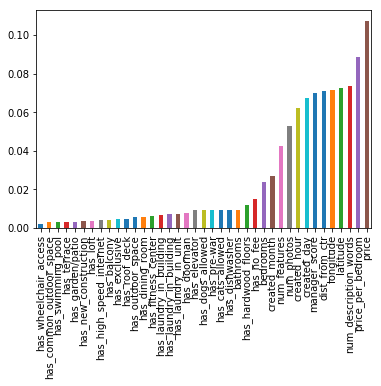

In [925]:
pd.Series(index = num_feats, data = clf.feature_importances_).sort_values().plot(kind = 'bar')

In [926]:
X.shape

(49033, 39)

## Making predictions on test data

### Read and feature engineer

In [927]:
test_df = pd.read_json(open("data/test.json", "r"))
test_df = feature_engineering(test_df)

/Users/vipul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """


In [928]:
test_df['building_score'].describe()

count    74659.000000
mean        42.458083
std         67.947383
min          0.000000
25%          3.000000
50%         14.000000
75%         48.000000
max        392.000000
Name: building_score, dtype: float64

### Predict

In [929]:
X = test_df[num_feats]
y = clf.predict_proba(X)

labels2idx = {label: i for i, label in enumerate(clf.classes_)}

sub = pd.DataFrame()
sub["listing_id"] = test_df["listing_id"]
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]

In [930]:
sub.to_csv("submission_rf.csv", index=False)

In [931]:
submission = pd.read_csv('submission_rf.csv')

In [932]:
submission.head()

,listing_id,high,medium,low
0,7142618,0.040,0.420,0.540
1,7210040,0.227,0.315,0.458
2,7103890,0.009,0.119,0.872
3,7143442,0.071,0.357,0.572
4,6860601,0.009,0.346,0.645


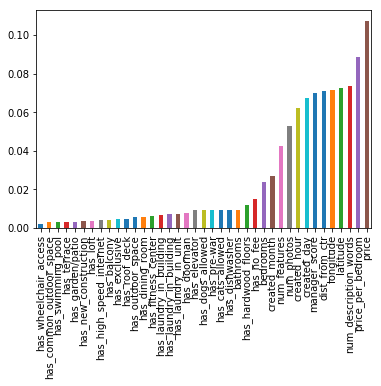

In [933]:
pd.Series(index = num_feats, data = clf.feature_importances_).sort_values().plot(kind = 'bar')